Requirements to run:

torch, matplotlib, opencv-python, tqdm, numpy

train_sims.npy, val_sims.npy, test_sims.npy (You may need to change the paths)

Data in 200x200 format with conductivity, pressure, and porosity. (Again, you may need to change path)

At the bottom in the evaluation section, there are some pre-named models. You should replace these with the names of your saved models.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)

In [12]:
# Pre-define steps and points to maintain a consistent validation set
val_steps = np.random.randint(1,199,(val_sims.shape[0],))
val_points = np.random.randint(0,149,(val_sims.shape[0],2))

In [13]:
# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

In [14]:
# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)

In [21]:
# Dataset used
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self, sims, unmask_size=20, points = None, block_size = 50, reveal_strategy = "block", n_points = 200, radius = 2, steps = None, H=200, W=200, channels="all"):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    def __getitem__(self, index):


        if not type(self.steps) == np.ndarray:
            step = np.random.randint(1,200)
        else:
            step = self.steps[index]

        # Create tensor for the target
        t = torch.tensor(get_all(self.sims[index], step))

        # Create 0-matrix
        z = torch.zeros_like(t)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":
            ii = torch.randint(0, self.H, (self.n_points,))
            jj = torch.randint(0, self.W, (self.n_points,))
            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk
            

        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        



        # write revealed pixels for selected channels
        chans = self._chan_idx()
        z[chans, :, :] = torch.where(mask, t[chans, :, :], torch.zeros_like(t[chans, :, :]))

        return z,t




        # If points and steps are specified, use those, otherwise randomize
        if not type(self.points) == np.ndarray:
            point = np.random.randint(0, 200-self.size, size=(2,))
        else:
            point = self.points[index]
        if not type(self.steps) == np.ndarray:
            step = np.random.randint(1,200)
        else:
            step = self.steps[index]

        # Create tensor for the target
        t = torch.tensor(get_all(self.sims[index], step))
        # Create 0-matrix
        z = torch.zeros_like(t)
        # Set points that are known to their values
        z[:,point[0]:point[0]+self.size,point[1]:point[1]+self.size] = t[:,point[0]:point[0]+self.size,point[1]:point[1]+self.size]
        
        return z,t
    
    def __len__(self):
        return self.sims.shape[0]
    
train_loader = torch.utils.data.DataLoader(MaskedDataset(train_sims, reveal_strategy="disks", n_points=12, radius=5), batch_size=8, shuffle=True)
# Val uses preset points and steps
val_data = MaskedDataset(
    val_sims,
    reveal_strategy="disks",
    n_points=12,
    radius=5,
    points=val_points,
    steps=val_steps
)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [16]:
model = SmallUnet().to(device)
optim = torch.optim.Adam(model.parameters())
schedule = torch.optim.lr_scheduler.ExponentialLR(optim, 0.99)
crit = nn.MSELoss()

In [17]:
# Parameter count
sum([k.numel() for k in model.parameters()])

2527461

In [18]:
# Pick epoch dount
epochs = 250
# train loss values, losses is total darcy is only darcy
losses = []
darcy = []
# similar for validation
val_loss = []
val_darcy = []

for e in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_darcy = 0
    for feat,label in train_loader:
        optim.zero_grad()
        feat = feat.to(device)
        label = label.to(device)
        # Process darcy loss and save it
        p_loss, out = darcy_loss(model, feat)
        epoch_darcy += p_loss.item()
        # Calculate total loss
        loss = p_loss + crit(out, label)
        epoch_loss += loss.item()
        # Perform backward step
        loss.backward()
        optim.step()
    # Track loss
    epoch_loss /= train_loader.__len__()
    epoch_darcy /= train_loader.__len__()
    losses.append(epoch_loss)
    darcy.append(epoch_darcy)

    schedule.step()

    epoch_loss = 0
    epoch_darcy = 0
    with torch.no_grad():
        for feat,label in val_loader:

            feat = feat.to(device)
            label = label.to(device)
            p_loss, out = darcy_loss(model, feat)
            epoch_darcy += p_loss.item()
            loss = p_loss + crit(out, label)
            epoch_loss += loss.item()

    epoch_loss /= val_loader.__len__()
    epoch_darcy /= val_loader.__len__()
    val_loss.append(epoch_loss)
    val_darcy.append(epoch_darcy)

100%|██████████| 250/250 [35:06<00:00,  8.43s/it]


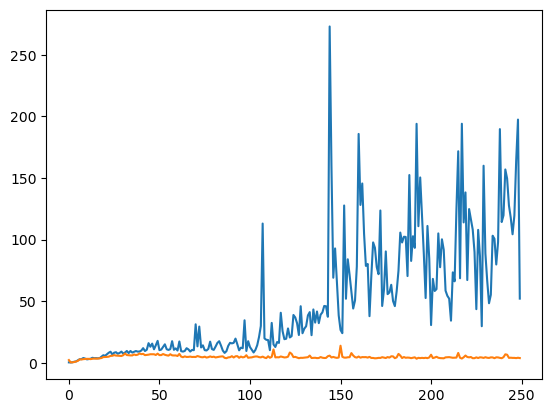

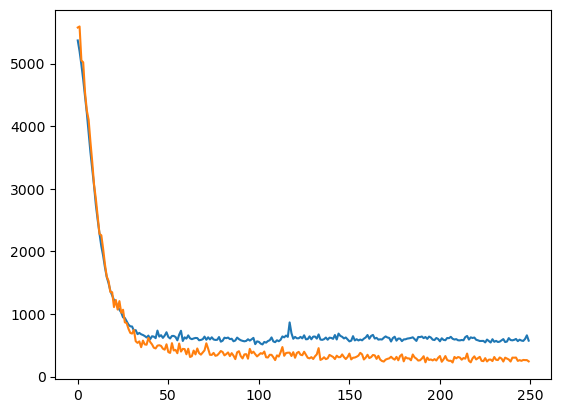

In [19]:
plt.plot(np.array(val_darcy))
plt.plot(np.array(darcy))
plt.show()
plt.plot(np.array(val_loss) - np.array(val_darcy))
plt.plot(np.array(losses) - np.array(darcy))
plt.show()

In [20]:
torch.save(model, "small_unet_darcy_50_nodarcy_disk.pt")

Now to actual evaluation

In [ ]:
# both_model = torch.load("small_unet_darcy_50_both-b1.pt", weights_only=False).to(device)
# darcy_model = torch.load("small_unet_darcy_50_nomse.pt", weights_only=False).to(device)
# mse_model = torch.load("small_unet_darcy_50_nodarcy.pt", weights_only=False).to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'small_unet_darcy_50_both-b1.pt'

In [22]:
def vis(tensor):
    return tensor.cpu().detach().numpy()

def show_evaluation(model, indices, data=val_data):

    fig, axs = plt.subplots(len(indices), 6, dpi=600)

    axs[0,0].set_title("Given K", fontsize=8)
    axs[0,1].set_title("Predicted K",fontsize=8)
    axs[0,2].set_title("Actual K",fontsize=8)

    axs[0,3].set_title("Given Pres",fontsize=8)
    axs[0,4].set_title("Predicted Pres",fontsize=8)
    axs[0,5].set_title("Actual Pres",fontsize=8)

    for i,e in enumerate(indices):
        sample = val_data.__getitem__(e)
        out = model(sample[0].to(device).unsqueeze(0))[0]

        axs[i,0].imshow(vis(sample[0][0]), cmap='gray', vmin=0, vmax=255)
        axs[i,1].imshow(vis(out[0]), cmap='gray', vmin=0, vmax=255)
        axs[i,2].imshow(vis(sample[1][0]), cmap='gray', vmin=0, vmax=255)

        axs[i,3].imshow(vis(sample[0][1]), cmap='gray', vmin=0, vmax=255)
        axs[i,4].imshow(vis(out[1]), cmap='gray', vmin=0, vmax=255)
        axs[i,5].imshow(vis(sample[1][1]), cmap='gray', vmin=0, vmax=255)

    for axs in fig.get_axes():
        axs.axis('off')
    fig.tight_layout()
    plt.show()

In [ ]:
# Model using only darcy loss
# show_evaluation(darcy_model, [9,6,12,17])

NameError: name 'darcy_model' is not defined

In [ ]:
# Model using only darcy loss
# show_evaluation(mse_model, [9,6,12,17])

NameError: name 'mse_model' is not defined

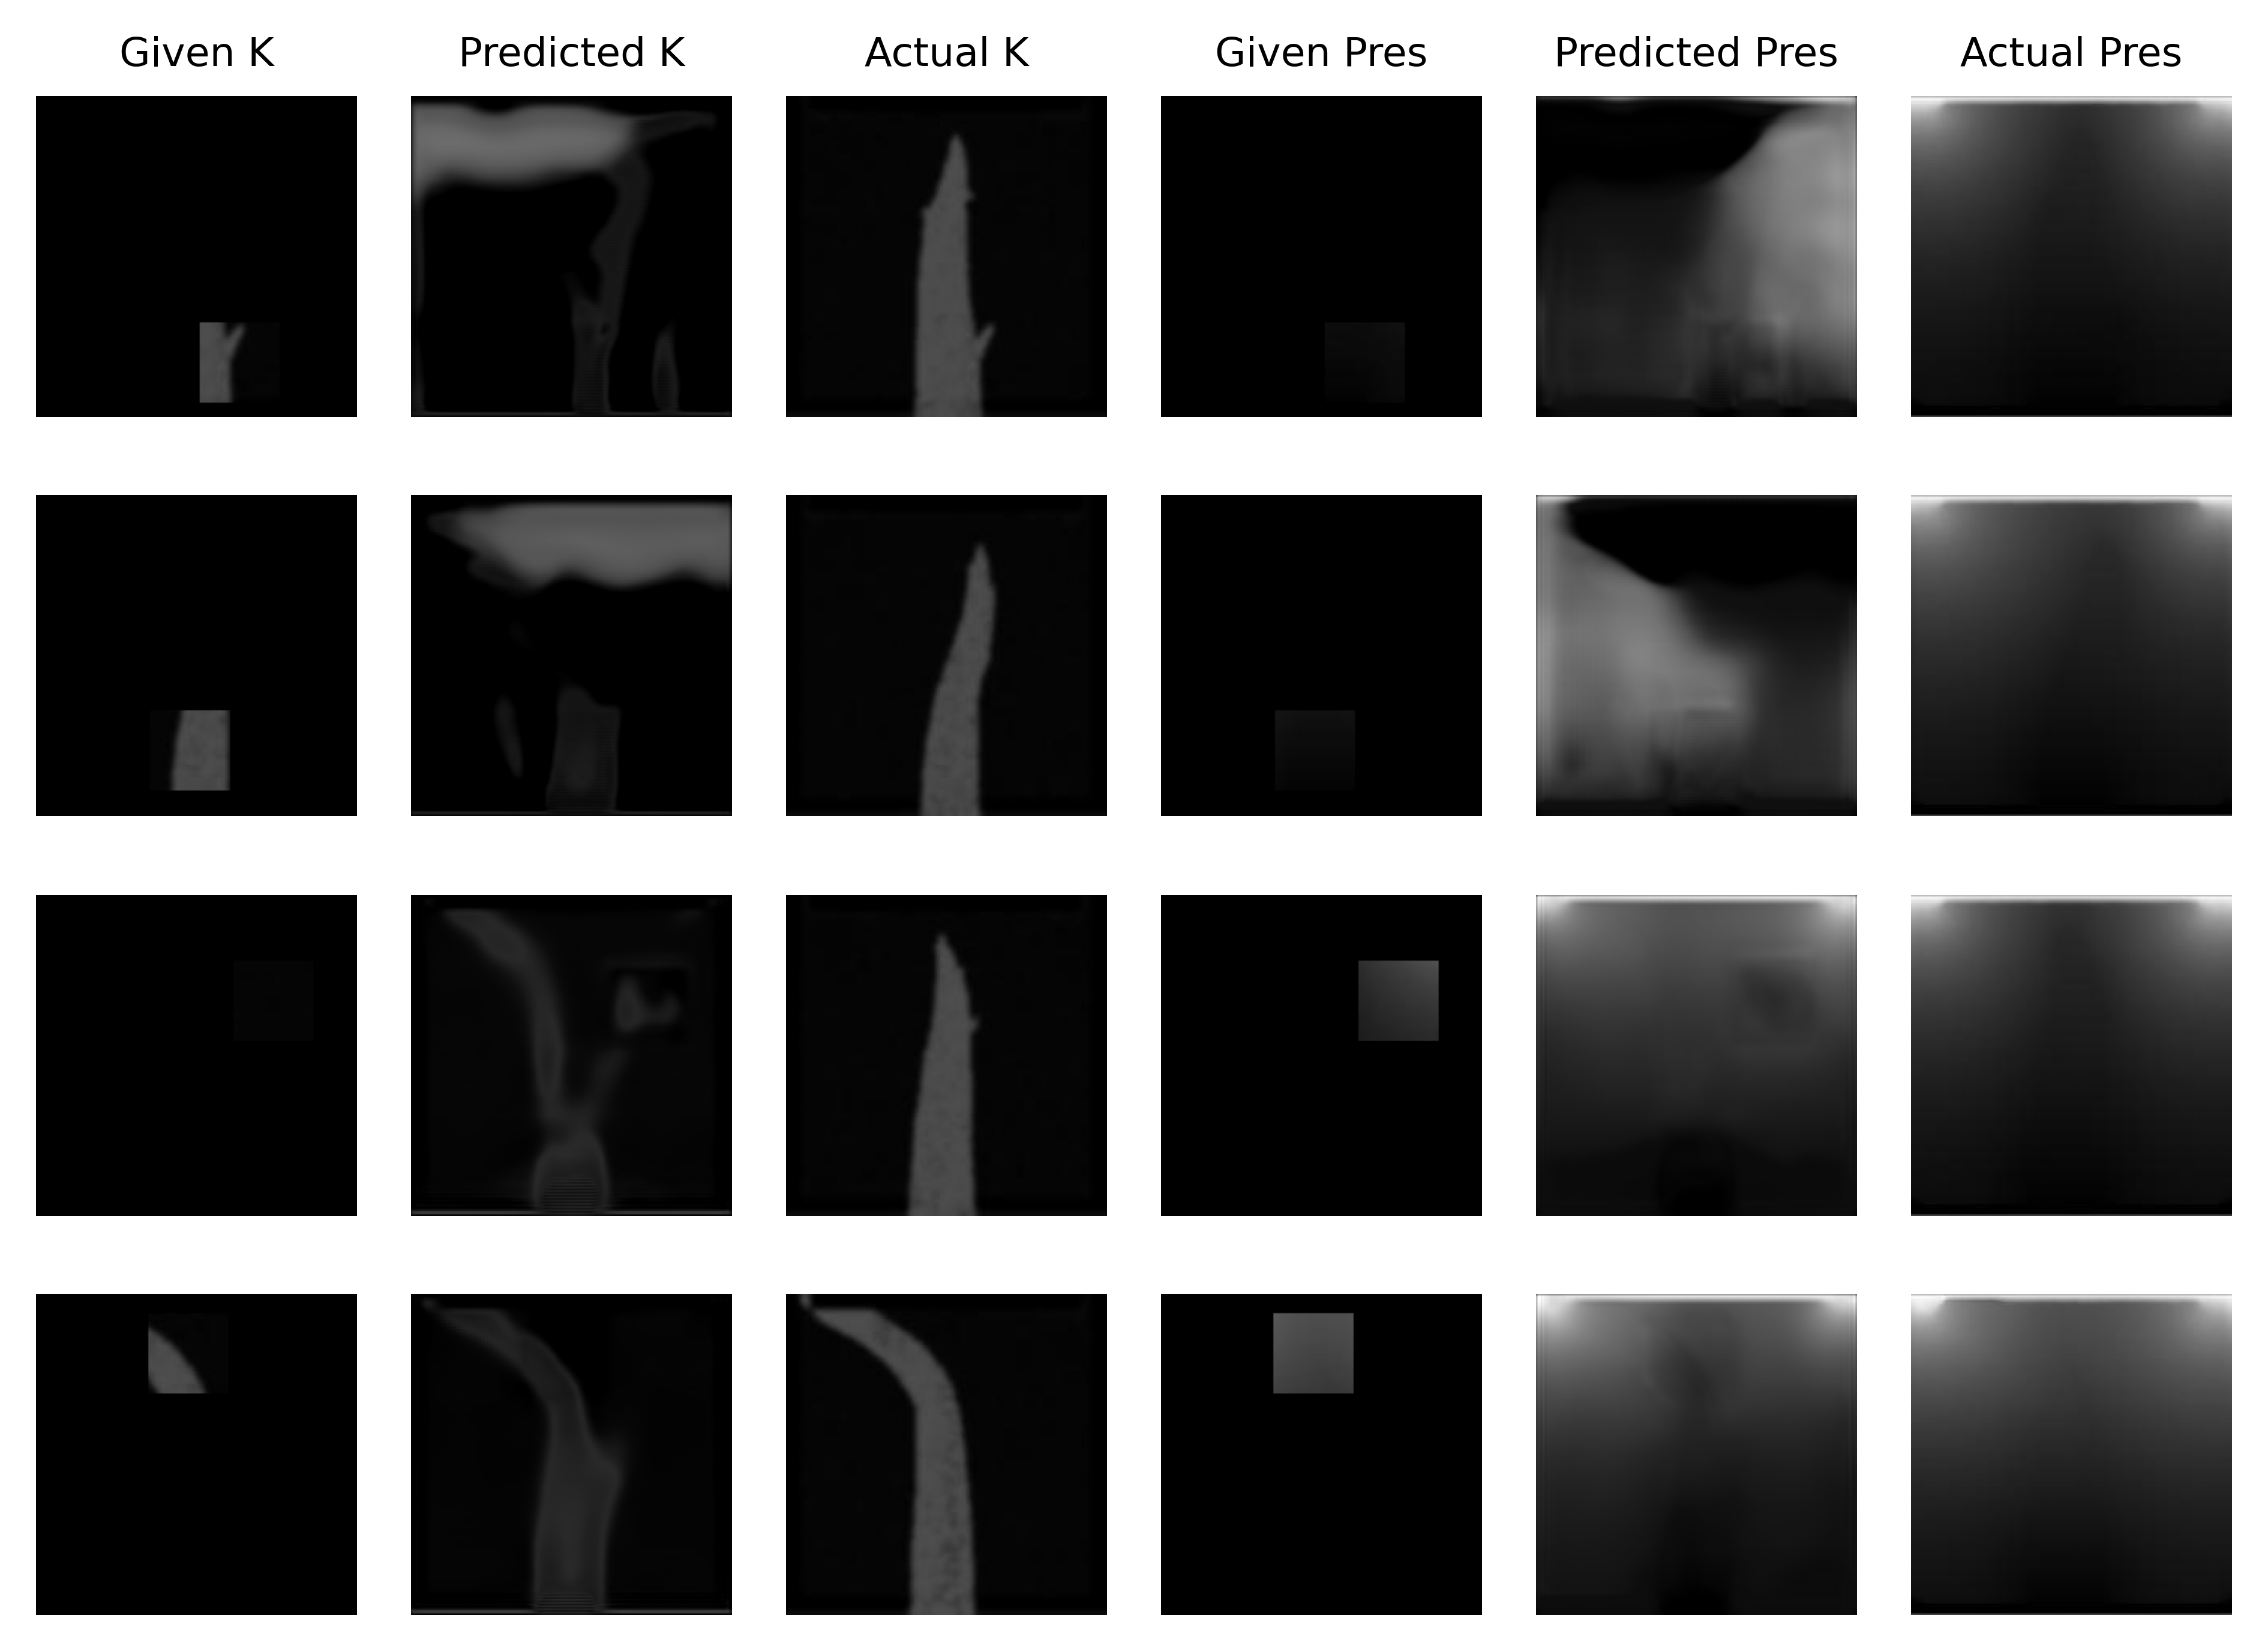

In [25]:
show_evaluation(model, [9,2,12,17])

In [26]:
created = torch.load("small_unet_darcy_50_nodarcy_disk.pt", weights_only=False).to(device)

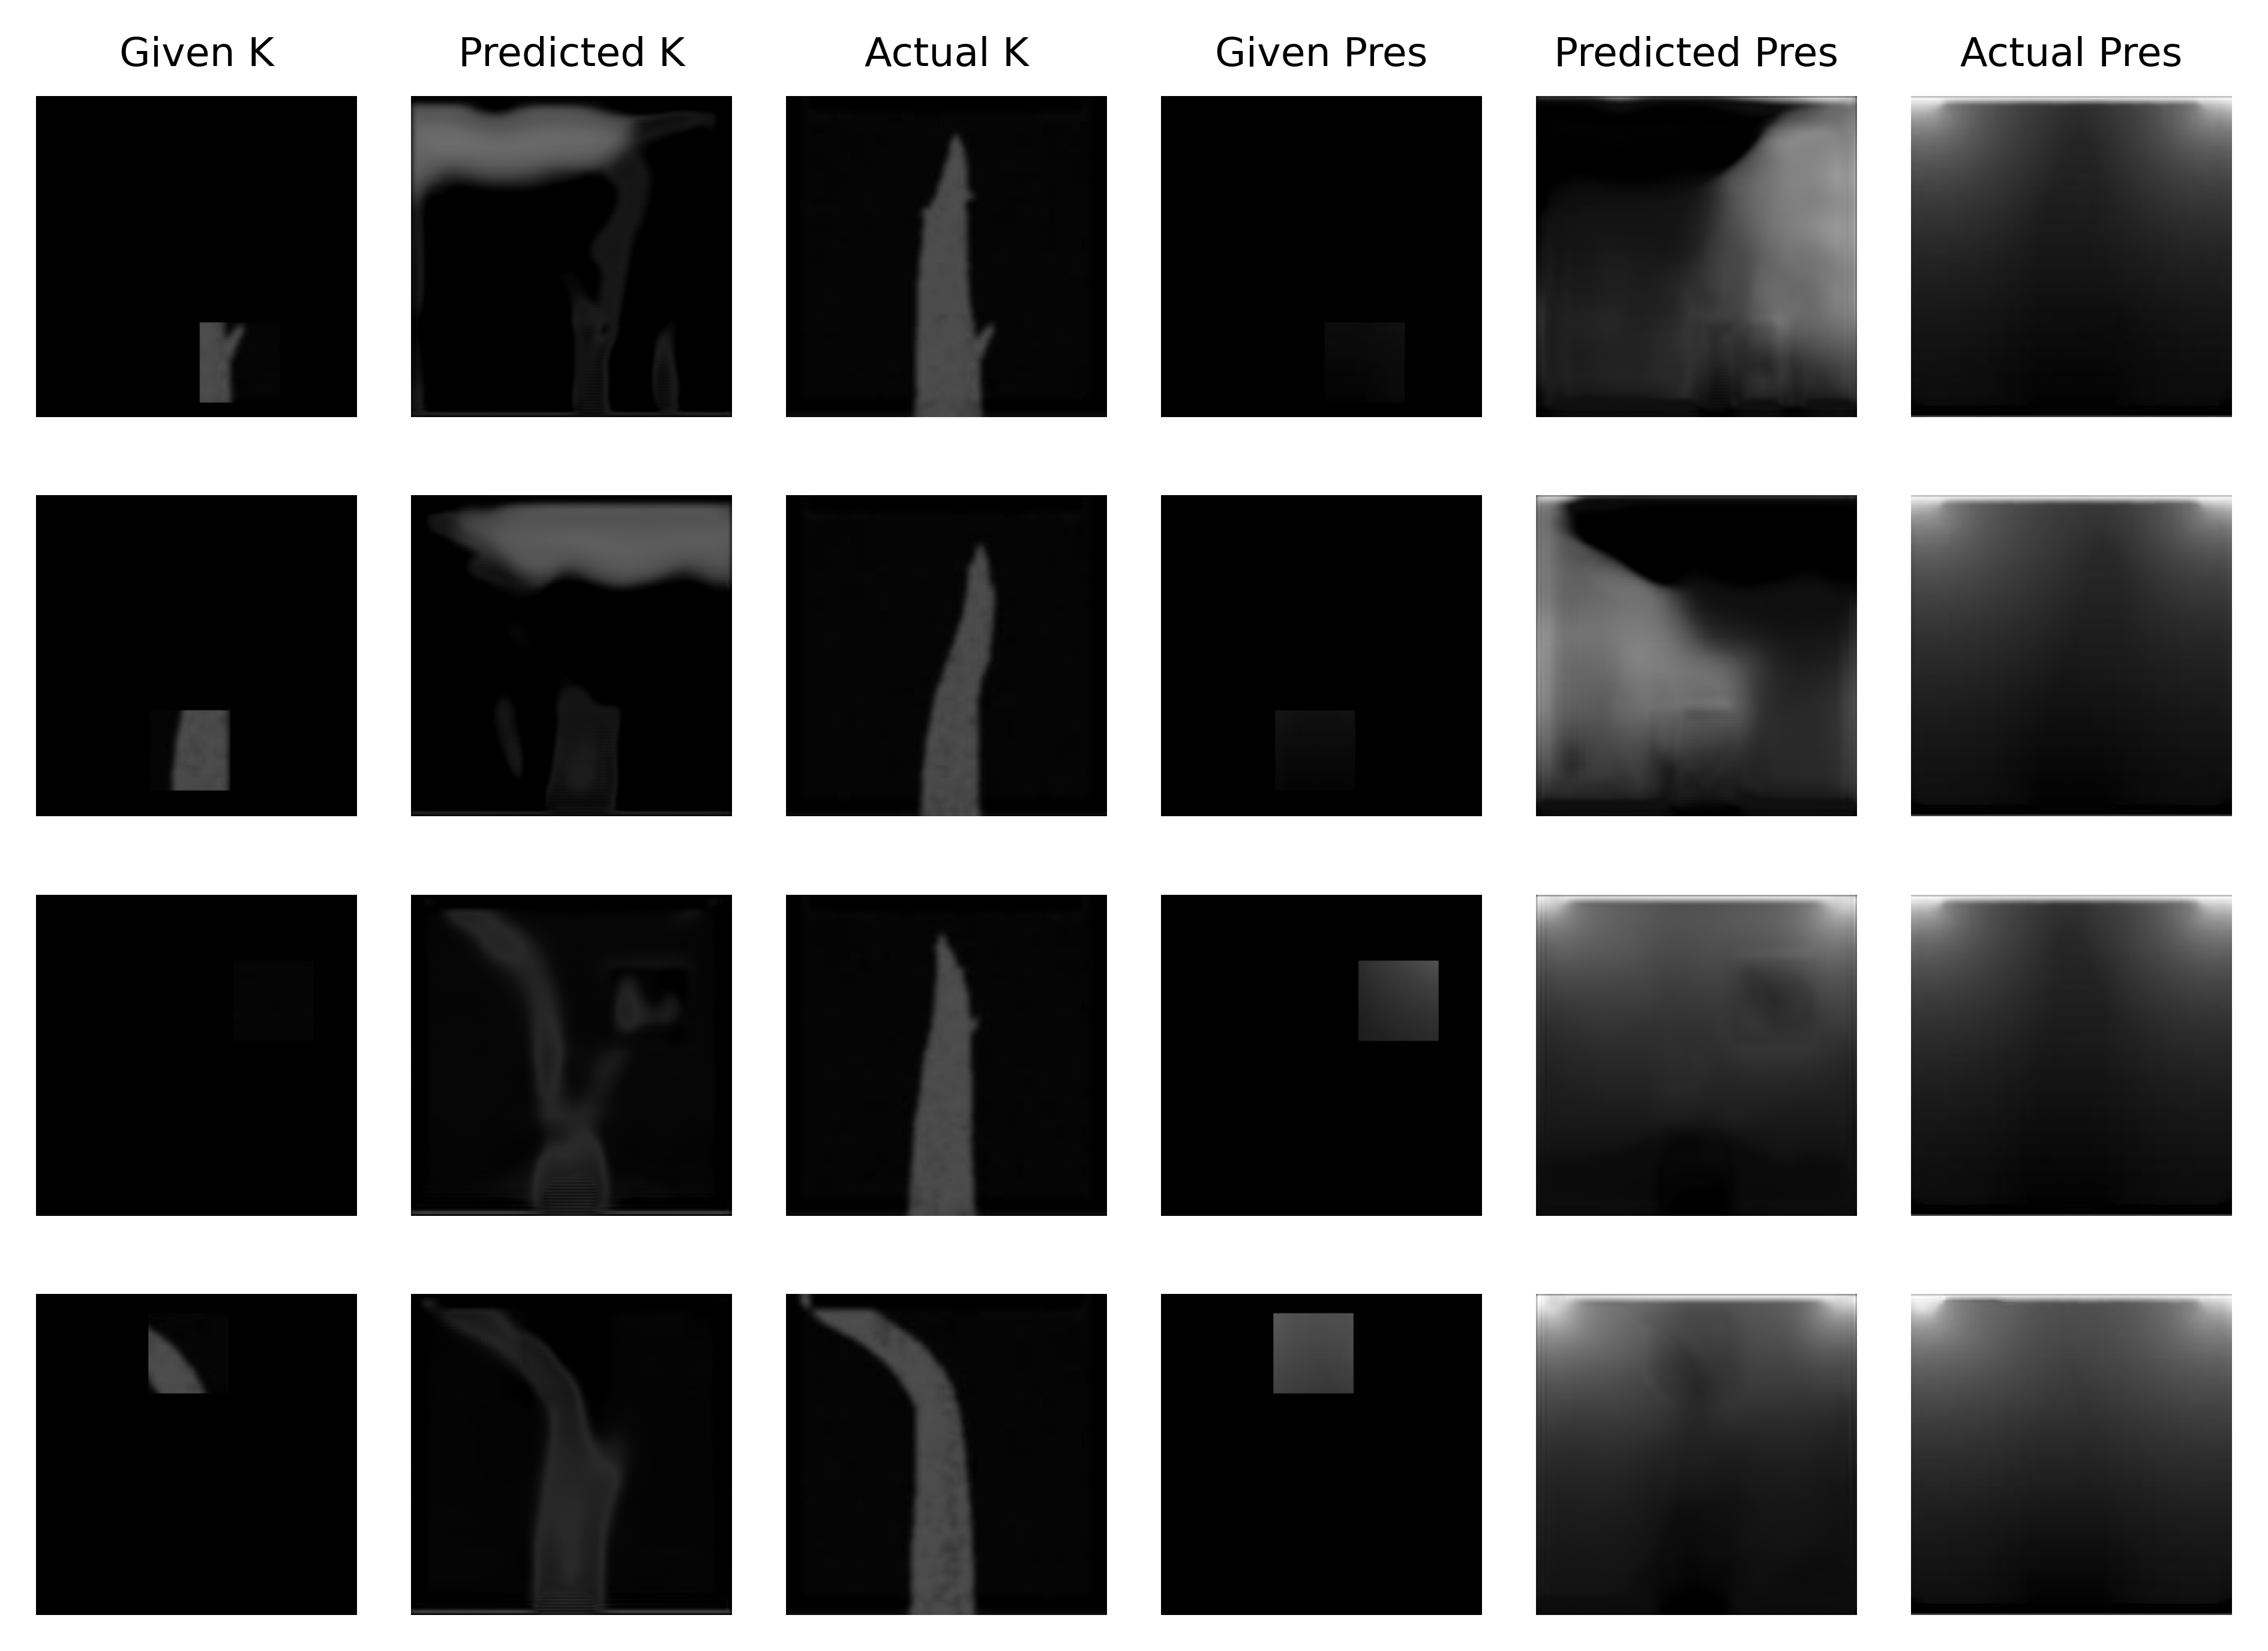

In [27]:
show_evaluation(created, [9,2,12,17])

In [23]:
created = torch.load("small_unet_darcy_50_nodarcy_disk.pt", weights_only=False).to(device)
model.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
show_evaluation(model, [9, 2, 12, 17])